In [ ]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.15.1

In [2]:
!gdown --id 19yR6-qVYJ6gQ-3HuXEOxjf-ZeaWJJruh
!unzip -qq -u words_captcha.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19yR6-qVYJ6gQ-3HuXEOxjf-ZeaWJJruh
From (redirected): https://drive.google.com/uc?id=19yR6-qVYJ6gQ-3HuXEOxjf-ZeaWJJruh&confirm=t&uuid=a2db0f94-5974-4605-8fc8-d054bc2f456f
To: /content/words_captcha.zip
100% 4.57G/4.57G [00:51<00:00, 89.6MB/s]


In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
IMAGE_SIZE = 224

In [5]:
# Store captions and image names in vectors
train_captions = []
img_name_vector = []

PATH = './words_captcha/'
with open(PATH + 'spec_train_val.txt', 'r') as f:
    for line in f:
        image_name, caption = line.split(' ')
        full_image_path = PATH + image_name + '.png'
        caption = '<start> ' + ' '.join(caption) + ' <end>'
        img_name_vector.append(full_image_path)
        train_captions.append(caption)

image_features_extract_model使用yolo的extractor部分

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

In [8]:
img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = conv_leaky_relu(img_inputs, 64, 7, 2)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 192, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 1, 1)
x = conv_leaky_relu(x, 256, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 256, 1, 1)
x = conv_leaky_relu(x, 512, 3, 1)
x = conv_leaky_relu(x, 512, 1, 1)
x = conv_leaky_relu(x, 1024, 3, 1)
outputs = layers.MaxPool2D()(x)
image_features_extract_model = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO_feature_extractor")

In [9]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [10]:
img_name_train = img_name_vector[:100000]
cap_train = cap_vector[:100000]
img_name_val = img_name_vector[100000:]
cap_val = cap_vector[100000:]



In [53]:
img_name_test = [PATH + f'a{i}.png' for i in range(120000,140000)]

In [11]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 50
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
LEARNING_RATE = 1e-4

把Parallel mapping、prefetch這些加速方法用上

In [12]:
def map_func(img_name, cap):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255 * 2 - 1
    return img, cap

def map_test(img_name):
    img = tf.io.read_file(img_name)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img / 255 * 2 - 1
    return img

In [13]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))\
        .shuffle(BUFFER_SIZE)\
        .map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
        .batch(BATCH_SIZE)\
        .prefetch(tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))\
        .map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
        .batch(BATCH_SIZE)\
        .prefetch(tf.data.experimental.AUTOTUNE)



In [54]:
dataset_test = tf.data.Dataset.from_tensor_slices(img_name_test)\
        .map(map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
        .batch(BATCH_SIZE)\
        .prefetch(tf.data.experimental.AUTOTUNE)

In [14]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [16]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [17]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [19]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(image_features_extract_model = image_features_extract_model,
                            encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [20]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [21]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [22]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = image_features_extract_model(img_tensor)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables + image_features_extract_model.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [23]:
EPOCHS = 10
start = time.time()
for epoch in range(start_epoch, EPOCHS):

    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset_train), total=num_steps):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

#         if batch % 100 == 0:
#             print ('Epoch {} Batch {} Loss {:.4f}'.format(
#               epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS, time.time() - start))

100%|██████████| 2000/2000 [07:22<00:00,  4.52it/s]


Epoch 1 Loss 1.500475


100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


Epoch 2 Loss 0.684144


100%|██████████| 2000/2000 [06:55<00:00,  4.82it/s]


Epoch 3 Loss 0.105266


100%|██████████| 2000/2000 [06:55<00:00,  4.82it/s]


Epoch 4 Loss 0.052427


100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


Epoch 5 Loss 0.034074


100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


Epoch 6 Loss 0.024379


100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


Epoch 7 Loss 0.018488


100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


Epoch 8 Loss 0.015587


100%|██████████| 2000/2000 [06:56<00:00,  4.81it/s]


Epoch 9 Loss 0.012971


100%|██████████| 2000/2000 [06:55<00:00,  4.81it/s]


Epoch 10 Loss 0.010134
Time taken for 10 epoch 4270.969752073288 sec



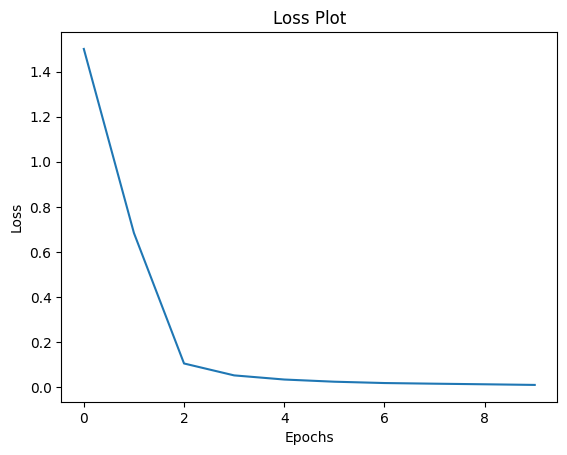

In [24]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [44]:
def get_str(result):
  ans = ''
  for i in result:
    i = i.numpy()
    if tokenizer.index_word[i] == '<end>':
      break
    elif tokenizer.index_word[i] == '<start>':
      continue
    ans += tokenizer.index_word[i]
  return ans

In [41]:
#TODO
def evaluate(img_tensor):

    hidden = decoder.reset_state(batch_size=BATCH_SIZE)

    features = image_features_extract_model(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
    result = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions ,axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((BATCH_SIZE, 1))], axis=1)

    return result

In [48]:
# captions on the validation set
right_count = 0

for (batch, (img_tensor, target)) in tqdm(enumerate(dataset_valid)):
  result_batch = evaluate(img_tensor)
  for id in range(BATCH_SIZE):
    if get_str(result_batch[id]) == get_str(target[id]):
      right_count += 1

print(f'validation accuracy:{right_count/len(img_name_val)}')

400it [03:31,  1.89it/s]


validation accuracy:0.9487


In [56]:
output_name = 'Lab12-2_110062209.txt'
with open(output_name, 'w') as f:

  for (batch, img_tensor) in tqdm(enumerate(dataset_test)):
    result_batch = evaluate(img_tensor)
    for id in range(BATCH_SIZE):
      f.write(f'a{120000+id+batch*BATCH_SIZE} {get_str(result_batch[id])}')

400it [02:32,  2.63it/s]


由於colab時間限制，我把epoch降到10，但10也夠把validation的accuracy提升到0.9487了